# DD2424 - Project
This is an altered version of the method presented in NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis

[Project website](http://www.matthewtancik.com/nerf)

Components not included in the notebook

* 5D input including view directions
* Hierarchical Sampling

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2020-05-04 17:32:36--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)...128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12,14M  4,37MB/s    in 2,8s    

2020-05-04 17:32:40 (4,37 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load input images and poses. 
The input images have size (100,100,3)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


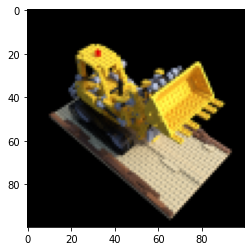

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# NeRF network

In [4]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

L_embed = 6
embed_fn = posenc

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Main function
render_rays() takes the model and a ray as input. Draw N_samples of points alone the ray. Run the network on these points, use the output to compute the the color and opacity(density). 

In [5]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    pr = cProfile.Profile()
    pr2 = cProfile.Profile()
    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    
    pr.enable()
    raw = batchify(network_fn)(pts_flat)
    pr.disable()
    ps = pstats.Stats(pr).sort_stats('tottime').dump_stats("[Profile]forward")
    
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    pr2.enable()
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)
    pr2.disable()
    ps = pstats.Stats(pr2).sort_stats('tottime').dump_stats("[Profile]rendering")
    
    return rgb_map, depth_map, acc_map

# Render a single image of the scene 

   0.000 unparser.py:538(_Constant)
        6    0.000    0.000    0.000    0.000 unparser.py:55(leave)
     99/2    0.000    0.000    0.000    0.000 unparser.py:59(dispatch)
        3    0.000    0.000    0.000    0.000 unparser.py:651(_Tuple)
       10    0.000    0.000    0.000    0.000 unparser.py:706(_Attribute)
      7/5    0.000    0.000    0.000    0.000 unparser.py:716(_Call)
        5    0.000    0.000    0.000    0.000 unparser.py:772(_arg)
        3    0.000    0.000    0.000    0.000 unparser.py:779(_arguments)
        4    0.000    0.000    0.000    0.000 unparser.py:837(_keyword)
        3    0.000    0.000    0.000    0.000 unparser.py:854(_alias)
        1    0.000    0.000    0.000    0.000 unparser.py:859(_withitem)
        2    0.000    0.000    0.000    0.000 unparser.py:88(_Expr)
        2    0.000    0.000    0.000    0.000 unsupported_features_checker.py:32(visit_Attribute)
        1    0.000    0.000    0.000    0.000 unsupported_features_checker.py:60(verify)


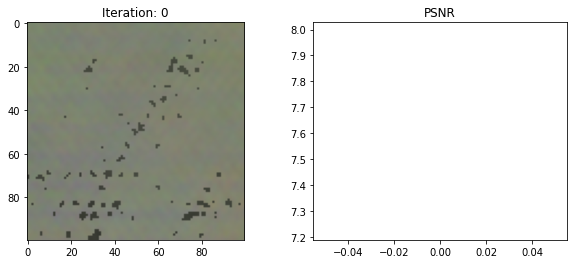

1
2
3


KeyboardInterrupt: 

In [6]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time, cProfile, pstats
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        #rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    
    cProfile.run("gradients = tape.gradient(loss, model.trainable_variables)", "[Profile]backprop")
    #gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        p = pstats.Stats('[Profile]forward')
        p.strip_dirs().sort_stats('tottime').print_stats(.01)

        p = pstats.Stats('[Profile]rendering')
        p.strip_dirs().sort_stats('tottime').print_stats(.01)

        p = pstats.Stats('[Profile]backprop')
        p.strip_dirs().sort_stats('tottime').print_stats(.01)
        # Render the holdout view for logging
        
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        print("PSNR: {}".format(psnr))
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        #plt.show()
        plt.savefig("PSNR_default.png")
print('Done')